# Met Éireann Reanalysis (MÉRA) - using GRIB files

<https://www.met.ie/climate/available-data/mera>

Issues:

- data uses 0/360 longitude coordinates instead of -180/180
  - data spans both negative and positive longitudes
- projection information is not parsed when the data is read
- lon/lat are multidimensional coordinates (y, x)
  - data with two-dimensional coordinates cannot be spatially selected (e.g.
    extracting data for a certain point, or clipping with a geometry)
  - x and y correspond to the index of the cells and are not coordinates in
    Lambert Conformal Conic projection

Solution:

- use CDO to convert the GRIB file to netCDF first
  - projection info is parsed and can be read by Xarray
  - one-dimensional coordinates in Lambert Conformal Conic projection
  - data can now be indexed or selected both spatially and temporally using
    Xarray
  - some metadata are lost (e.g. variable name and attributes) but these can
    be reassigned manually
  - this method combines all three time steps in the example data (data needs
    to be split prior to conversion to avoid this)

Relevant links:

- <https://docs.xarray.dev/en/stable/examples/multidimensional-coords.html>
- <https://docs.xarray.dev/en/stable/examples/ERA5-GRIB-example.html>
- <https://scitools.org.uk/cartopy/docs/latest/reference/projections.html>
- <https://confluence.ecmwf.int/display/OIFS/How+to+convert+GRIB+to+netCDF>

Example data used:
<https://www.met.ie/downloads/MERA_PRODYEAR_2015_06_11_105_2_0_FC3hr.grb>

Requirements:

- CDO
- Python 3.10
  - rioxarray
  - geopandas
  - dask
  - cartopy
  - matplotlib
  - nc-time-axis
  - pooch
  - netcdf4
  - cfgrib

In [1]:
import os
from datetime import date, datetime, timezone
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.units as munits
import numpy as np
import pooch
import xarray as xr

In [2]:
# Moorepark, Fermoy met station coords
LON, LAT = -8.26389, 52.16389

In [3]:
# Ireland boundary (derived from NUTS 2021)
GPKG_BOUNDARY = os.path.join("data", "boundaries", "boundaries_all.gpkg")
ie = gpd.read_file(GPKG_BOUNDARY, layer="NUTS_RG_01M_2021_2157_IE")

In [4]:
DATA_DIR = os.path.join("data", "MERA", "sample")
os.makedirs(DATA_DIR, exist_ok=True)

In [5]:
URL = "https://www.met.ie/downloads/MERA_PRODYEAR_2015_06_11_105_2_0_FC3hr.grb"
FILE_NAME = "MERA_PRODYEAR_2015_06_11_105_2_0_FC3hr"

In [6]:
# download data if necessary
# sample GRIB data; 2 m temperature; 3-h forecasts
if not os.path.isfile(os.path.join(DATA_DIR, FILE_NAME)):
    pooch.retrieve(
        url=URL, known_hash=None, fname=f"{FILE_NAME}.grb", path=DATA_DIR
    )

    with open(
        os.path.join(DATA_DIR, f"{FILE_NAME}.txt"), "w", encoding="utf-8"
    ) as outfile:
        outfile.write(
            f"Data downloaded on: {datetime.now(tz=timezone.utc)}\n"
            f"Download URL: {URL}"
        )

In [7]:
# path to example data file
BASE_FILE_NAME = os.path.join(DATA_DIR, FILE_NAME)

## Read original GRIB data

In [8]:
data = xr.open_dataset(
    f"{BASE_FILE_NAME}.grb",
    decode_coords="all",
    chunks="auto",
    engine="cfgrib",
)

In [9]:
data

<xarray.Dataset>
Dimensions:            (time: 240, step: 3, y: 489, x: 529)
Coordinates:
  * time               (time) datetime64[ns] 2015-06-01 ... 2015-06-30T21:00:00
  * step               (step) timedelta64[ns] 01:00:00 02:00:00 03:00:00
    heightAboveGround  float64 ...
    latitude           (y, x) float64 dask.array<chunksize=(489, 529), meta=np.ndarray>
    longitude          (y, x) float64 dask.array<chunksize=(489, 529), meta=np.ndarray>
    valid_time         (time, step) datetime64[ns] dask.array<chunksize=(240, 3), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    t                  (time, step, y, x) float32 dask.array<chunksize=(194, 1, 398, 432), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             eidb
    GRIB_centreDescription:  Dublin
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Dublin
    history:                 2023-04-01T21:49 GRIB to CDM+CF via cfgrib-0.9.1...

In [10]:
# view CRS
data.rio.crs

In [22]:
# save variable attributes
t_attrs = data["t"].attrs

In [25]:
# convert 0/360 deg to -180/180 deg lon
long_attrs = data.longitude.attrs
data = data.assign_coords(longitude=(((data.longitude + 180) % 360) - 180))
# reassign attributes
data.longitude.attrs = long_attrs

### Plots

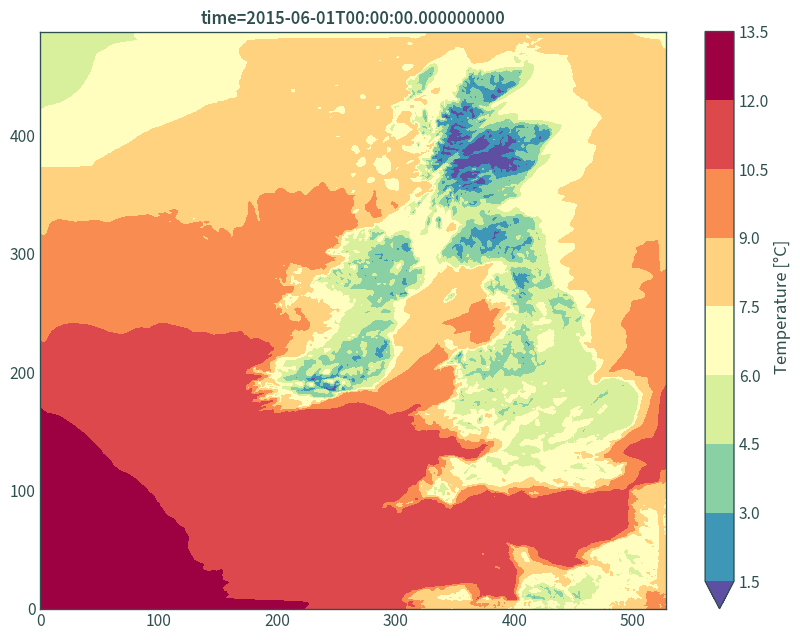

In [26]:
plt.figure(figsize=(9, 7))
(data.isel(time=0, step=2)["t"] - 273.15).plot.contourf(
    robust=True,
    cmap="Spectral_r",
    levels=11,
    cbar_kwargs={"label": "Temperature [°C]"},
)
plt.tight_layout()
plt.xlabel(None)
plt.ylabel(None)
plt.title(f"time={data.isel(time=0, step=2)['t']['time'].values}")
plt.show()

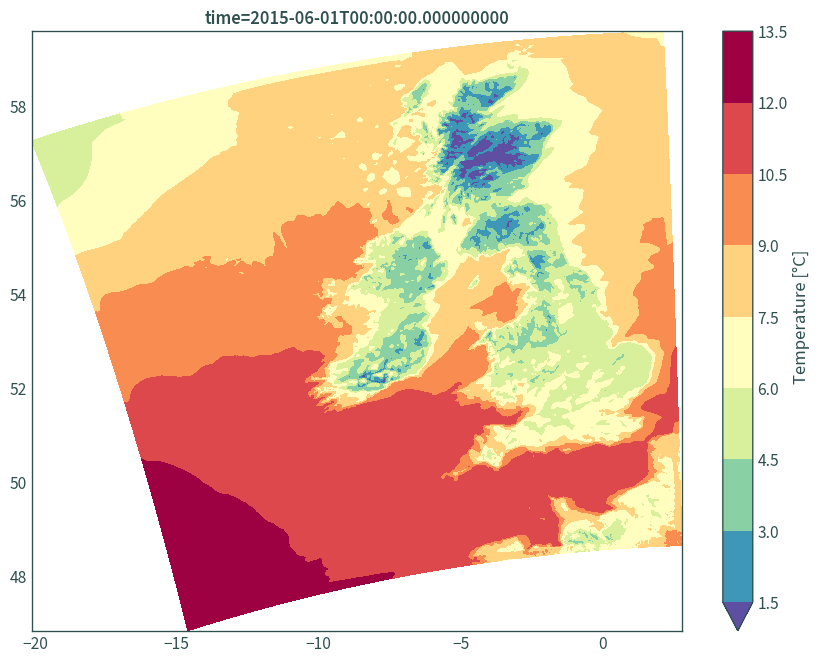

In [27]:
# specifying lon/lat as the x/y axes
plt.figure(figsize=(9, 7))
(data.isel(time=0, step=2)["t"] - 273.15).plot.contourf(
    robust=True,
    cmap="Spectral_r",
    x="longitude",
    y="latitude",
    cbar_kwargs={"label": "Temperature [°C]"},
    levels=11,
)
plt.xlabel(None)
plt.ylabel(None)
plt.title(f"time={data.isel(time=0, step=2)['t']['time'].values}")
plt.tight_layout()
plt.show()

## Convert GRIB to netCDF using CDO

In [15]:
# keep only the third forecast step and convert to netCDF
os.system(
    f"cdo -s -f nc4c -copy -seltimestep,3/{len(data['time']) * 3}/3 "
    f"{BASE_FILE_NAME}.grb {BASE_FILE_NAME}.nc"
)

0

## Read data

In [16]:
data = xr.open_dataset(
    f"{BASE_FILE_NAME}.nc", decode_coords="all", chunks="auto"
)

In [17]:
data

<xarray.Dataset>
Dimensions:            (time: 240, x: 529, y: 489, height: 1)
Coordinates:
  * time               (time) datetime64[ns] 2015-06-01T03:00:00 ... 2015-07-01
  * x                  (x) float64 0.0 2.5e+03 5e+03 ... 1.318e+06 1.32e+06
  * y                  (y) float64 0.0 2.5e+03 5e+03 ... 1.218e+06 1.22e+06
    Lambert_Conformal  int32 ...
  * height             (height) float64 2.0
Data variables:
    var11              (time, height, y, x) float32 dask.array<chunksize=(194, 1, 399, 432), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sat Mar 25 22:55:27 2023: cdo -s -f nc4c -copy -seltimestep...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [18]:
data.rio.crs

CRS.from_wkt('PROJCS["undefined",GEOGCS["undefined",DATUM["undefined",SPHEROID["undefined",6367470,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_1SP"],PARAMETER["latitude_of_origin",53.5],PARAMETER["central_meridian",5],PARAMETER["scale_factor",1],PARAMETER["false_easting",1481641.67696368],PARAMETER["false_northing",537326.063885016],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [19]:
# reassign attributes and rename variables
data["var11"].attrs = t_attrs
data = data.rename({"var11": "t"})

In [20]:
data

<xarray.Dataset>
Dimensions:            (time: 240, x: 529, y: 489, height: 1)
Coordinates:
  * time               (time) datetime64[ns] 2015-06-01T03:00:00 ... 2015-07-01
  * x                  (x) float64 0.0 2.5e+03 5e+03 ... 1.318e+06 1.32e+06
  * y                  (y) float64 0.0 2.5e+03 5e+03 ... 1.218e+06 1.22e+06
    Lambert_Conformal  int32 ...
  * height             (height) float64 2.0
Data variables:
    t                  (time, height, y, x) float32 dask.array<chunksize=(194, 1, 399, 432), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sat Mar 25 22:55:27 2023: cdo -s -f nc4c -copy -seltimestep...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

## Plots

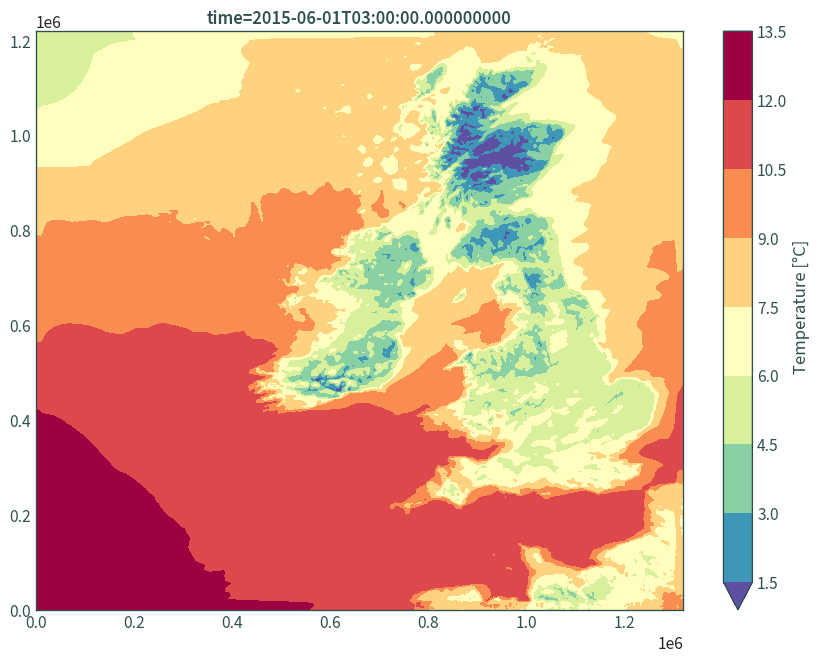

In [21]:
plt.figure(figsize=(9, 7))
(data.isel(time=0, height=0)["t"] - 273.15).plot.contourf(
    robust=True,
    cmap="Spectral_r",
    levels=11,
    cbar_kwargs={"label": "Temperature [°C]"},
)
plt.xlabel(None)
plt.ylabel(None)
plt.title(f"time={data.isel(time=0, height=0)['t']['time'].values}")
plt.tight_layout()
plt.show()

In [22]:
# define Lambert Conformal Conic projection for plots and transformations
# using metadata
lambert_conformal = ccrs.LambertConformal(
    false_easting=data["Lambert_Conformal"].attrs["false_easting"],
    false_northing=data["Lambert_Conformal"].attrs["false_northing"],
    standard_parallels=[data["Lambert_Conformal"].attrs["standard_parallel"]],
    central_longitude=(
        data["Lambert_Conformal"].attrs["longitude_of_central_meridian"]
    ),
    central_latitude=(
        data["Lambert_Conformal"].attrs["latitude_of_projection_origin"]
    ),
)

In [23]:
lambert_conformal

<Derived Projected CRS: +proj=lcc +ellps=WGS84 +lon_0=5.0 +lat_0=53.5 +x_0 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (1SP)
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

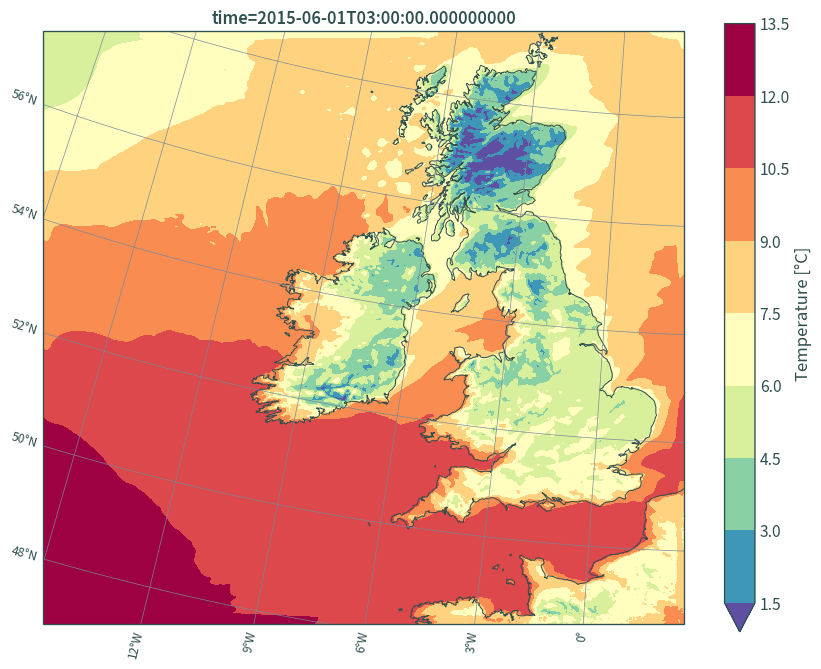

In [24]:
plt.figure(figsize=(9, 7))
ax = plt.axes(projection=lambert_conformal)
(data.isel(time=0, height=0)["t"] - 273.15).plot.contourf(
    ax=ax,
    robust=True,
    cmap="Spectral_r",
    x="x",
    y="y",
    levels=11,
    transform=lambert_conformal,
    cbar_kwargs={"label": "Temperature [°C]"},
)
ax.gridlines(
    draw_labels={"bottom": "x", "left": "y"},
    color="lightslategrey",
    linewidth=0.5,
    x_inline=False,
    y_inline=False,
)
ax.coastlines(resolution="10m", color="darkslategrey", linewidth=0.75)
plt.title(f"time={data.isel(time=0, height=0)['t']['time'].values}")
plt.tight_layout()
plt.show()

## Clip to boundary of Ireland

In [25]:
data_ie = data.rio.clip(
    ie.buffer(1).to_crs(lambert_conformal), all_touched=True
)

In [26]:
data_ie

<xarray.Dataset>
Dimensions:            (time: 240, x: 158, y: 166, height: 1)
Coordinates:
  * time               (time) datetime64[ns] 2015-06-01T03:00:00 ... 2015-07-01
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
  * height             (height) float64 2.0
    spatial_ref        int64 0
    Lambert_Conformal  int64 0
Data variables:
    t                  (time, height, y, x) float32 dask.array<chunksize=(194, 1, 166, 158), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sat Mar 25 22:55:27 2023: cdo -s -f nc4c -copy -seltimestep...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

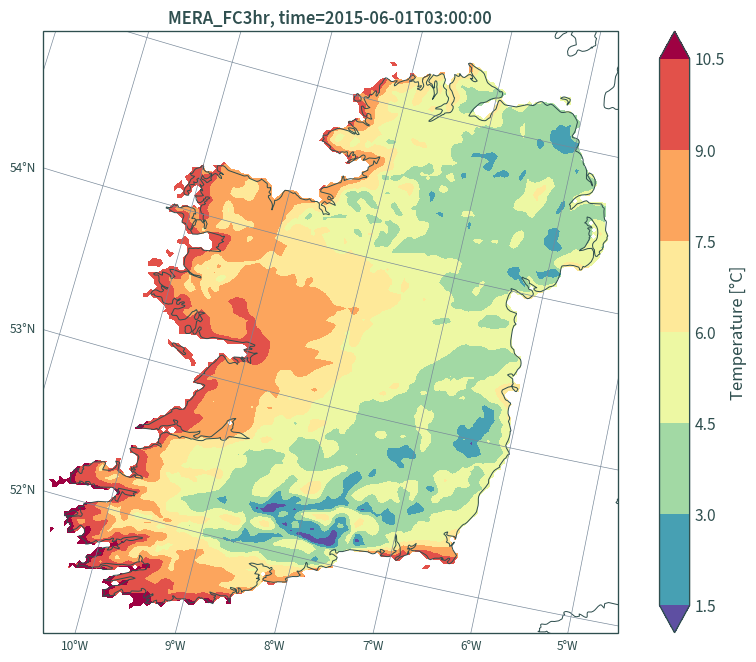

In [27]:
# contour plot
plt.figure(figsize=(9, 7))
ax = plt.axes(projection=ccrs.EuroPP())
(data_ie.isel(time=0, height=0)["t"] - 273.15).plot.contourf(
    ax=ax,
    robust=True,
    cmap="Spectral_r",
    x="x",
    y="y",
    levels=8,
    transform=lambert_conformal,
    cbar_kwargs={"label": "Temperature [°C]"},
)
ax.gridlines(
    draw_labels={"bottom": "x", "left": "y"},
    color="lightslategrey",
    linewidth=0.5,
    x_inline=False,
    y_inline=False,
)
ax.coastlines(resolution="10m", color="darkslategrey", linewidth=0.75)
plt.title(
    "MERA_FC3hr, "
    + f"time={str(data_ie.isel(time=0, height=0)['t']['time'].values)[:19]}"
)
plt.tight_layout()
plt.show()

In [28]:
# find number of grid cells with data
len(
    data_ie.isel(time=0, height=0)["t"].values.flatten()[
        np.isfinite(data_ie.isel(time=0, height=0)["t"].values.flatten())
    ]
)

14490

## Time series for a point (Moorepark)

In [29]:
# transform coordinates from lon/lat to Lambert Conformal Conic
XLON, YLAT = lambert_conformal.transform_point(
    x=LON, y=LAT, src_crs=ccrs.PlateCarree()
)

In [30]:
XLON, YLAT

(579021.4574730808, 472854.55040691514)

In [31]:
# extract data for the nearest grid cell to the point
data_ts = data_ie.sel({"x": XLON, "y": YLAT}, method="nearest")

In [32]:
data_ts

<xarray.Dataset>
Dimensions:            (time: 240, height: 1)
Coordinates:
  * time               (time) datetime64[ns] 2015-06-01T03:00:00 ... 2015-07-01
    x                  float64 5.8e+05
    y                  float64 4.725e+05
  * height             (height) float64 2.0
    spatial_ref        int64 0
    Lambert_Conformal  int64 0
Data variables:
    t                  (time, height) float32 dask.array<chunksize=(194, 1), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sat Mar 25 22:55:27 2023: cdo -s -f nc4c -copy -seltimestep...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

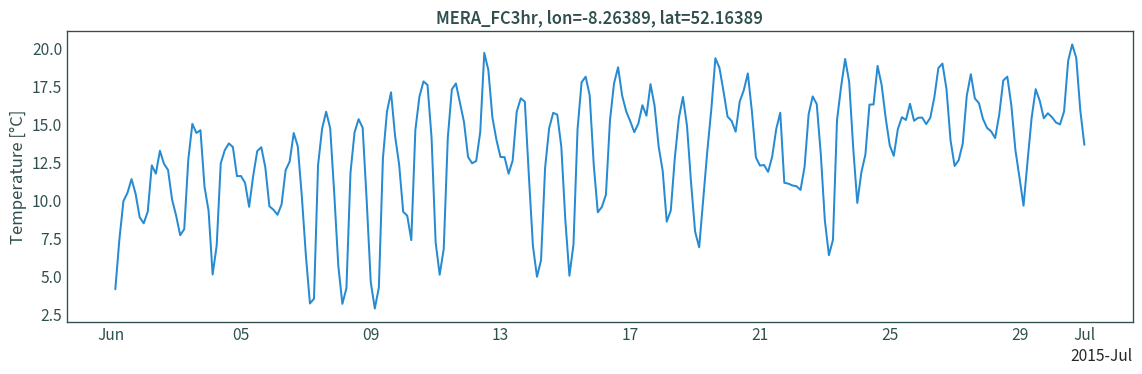

In [35]:
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[date] = converter
munits.registry[datetime] = converter

plt.figure(figsize=(12, 4))
plt.plot(data_ts["time"], (data_ts["t"] - 273.15))
plt.ylabel("Temperature [°C]")
plt.title(f"MERA_FC3hr, lon={LON}, lat={LAT}")
plt.tight_layout()
plt.show()